O objetivo deste trabalho é realizar uma classificação de tipos de choro infantil usando redes neurais convolucionais.

Vamos utilizar o banco de dados "Donate a Cry", disponível no Kaggle: https://www.kaggle.com/datasets/warcoder/infant-cry-audio-corpus/data.

O banco é composto por amostras de choro infantil de 5 tipos:
- Dor
- Gases
- Desconforto
- Fome
- Sono

Essa classificação foi realizada pelos pais/tutores dos bebês, baseados no que cessou o choro. 

Para alcançar nosso objetivo vamos seguir o fluxo:
- Ler os dados
- Transformar o sinal em imagem (espectrogramas)
- Desenvolver uma CNN
- Treinar a CNN
- Testar o desempenho com uma nova amostra de dados

In [1]:
import numpy as np
import os
import pandas as pd
import pathlib as Path
import librosa
import librosa.display
import matplotlib.pyplot as plt


As funções a seguir transformam o sinal de áudio do arquivo .wav em imagens (espectrogramas)

In [2]:
def create_spectrogram(audio_file, image_file):
    # Cria a figura para o espectrograma
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # Carrega o áudio e cria o espectrograma
    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    # Salva o espectrograma como imagem
    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    # Cria a pasta de saída se não existir
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Lista os arquivos na pasta de entrada
    dir = os.listdir(input_path)

    # Processa cada arquivo .wav e gera o espectrograma
    for i, file in enumerate(dir):
        if file.endswith('.wav'):  # Verifica se é um arquivo .wav
            input_file = os.path.join(input_path, file)
            output_file = os.path.join(output_path, file.replace('.wav', '.png'))
            create_spectrogram(input_file, output_file)

Agora definimos as pastas que receberão as imagens

In [3]:
pain_input = r"C:\Users\hanna\OneDrive\Documentos\Doutorado\piloto_donateacry\donateacry_corpus\belly_pain"
pain_output = r"C:\Users\hanna\OneDrive\Documentos\Doutorado\piloto_donateacry\donateacry_corpus\output_pain"
hungry_input = r"C:\Users\hanna\OneDrive\Documentos\Doutorado\piloto_donateacry\donateacry_corpus\hungry"
hungry_output = r"C:\Users\hanna\OneDrive\Documentos\Doutorado\piloto_donateacry\donateacry_corpus\output_hungry"

In [4]:
# Chama a função para gerar os espectrogramas
create_pngs_from_wavs(pain_input, pain_output)
create_pngs_from_wavs(hungry_input, hungry_output)


In [5]:
import tensorflow

Agora carregamos as imagens, convertemos em arrays e rotulamos os dados de imagem

In [6]:
x = []
y = []

from keras.preprocessing import image # type: ignore

def load_images_from_path(path, label):
    images = [] #lista para armazenar as imagens
    labels = [] #lista para armazenar os rótulos

    for file in os.listdir(path): #itera sobre os arquivos da pasta
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3)))) #carrega, redimensiona e transforma as imagens em arrays
        labels.append((label))

    return images, labels

Separamos os arquivos de treino e teste

In [7]:
from pathlib import Path
import shutil

def move_files(source_pattern, destination_path):
    # Cria o diretório de destino se não existir
    destination = Path(destination_path)
    destination.mkdir(parents=True, exist_ok=True)

    # Obtém o diretório de origem a partir do padrão
    source_dir = Path(source_pattern).parent
    file_pattern = Path(source_pattern).name

    # Encontra e move os arquivos que correspondem ao padrão
    for file_path in source_dir.glob(file_pattern):
        shutil.move(str(file_path), destination)
        print(f"Moved {file_path} to {destination}")

# Define seus diretórios e padrões de origem
directories = {
    r'C:\Users\hanna\OneDrive\Documentos\Doutorado\piloto_donateacry\donateacry_corpus\pain_train/': r'C:\Users\hanna\OneDrive\Documentos\Doutorado\piloto_donateacry\donateacry_corpus\output_pain\*.png',
    r'C:\Users\hanna\OneDrive\Documentos\Doutorado\piloto_donateacry\donateacry_corpus\hungry_train/': r'C:\Users\hanna\OneDrive\Documentos\Doutorado\piloto_donateacry\donateacry_corpus\output_hungry\*.png'
}

# Move os arquivos
for directory, source_pattern in directories.items():
    move_files(source_pattern, directory)


Error: Destination path 'C:\Users\hanna\OneDrive\Documentos\Doutorado\piloto_donateacry\donateacry_corpus\pain_train\549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.png' already exists

Agora criamos as pastas de treino com os dados rotulados

In [8]:
images, labels = load_images_from_path(r'C:\Users\hanna\OneDrive\Documentos\Doutorado\piloto_donateacry\donateacry_corpus\pain_train', 0)

x += images
y += labels

In [9]:
images, labels = load_images_from_path(r'C:\Users\hanna\OneDrive\Documentos\Doutorado\piloto_donateacry\donateacry_corpus\hungry_train', 1)

x += images
y += labels

In [10]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Normalization, Resizing, InputLayer
from tensorflow.keras.optimizers import AdamW

In [13]:
model = Sequential()

# Entrada e pré-processamento
model.add(InputLayer(input_shape=(224, 224, 3)))  # Define o tamanho de entrada da imagem
model.add(Resizing(64, 64))                       # Redimensiona para reduzir a complexidade do modelo
model.add(Normalization())                        # Normalização para estabilizar o treinamento

# Camadas convolucionais
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Camada convolucional adicional para maior capacidade de aprendizado
model.add(Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Camada densa e saída
model.add(Flatten())
model.add(Dense(128, activation='relu'))          # Camada totalmente conectada
model.add(Dropout(0.4))                           # Dropout para reduzir overfitting
model.add(Dense(1, activation='sigmoid'))         # Saída para classificação binária

# Compilação do modelo
model.compile(optimizer=AdamW(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


c:\Users\hanna\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 64, 64, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,759,688 (33.42 MB)

 Trainable params: 8,759,681 (33.42 MB)

 Non-trainable params: 7 (32.00 B)

In [21]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [22]:
# Certifique-se de usar os rótulos codificados
history = model.fit(
    x_train_norm, y_train,   # Rótulos codificados como one-hot
    validation_data=(x_test_norm, y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9400 - loss: 0.6305 - val_accuracy: 0.9245 - val_loss: 0.4300
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9477 - loss: 0.2477 - val_accuracy: 0.9245 - val_loss: 0.2914
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9349 - loss: 0.3320 - val_accuracy: 0.9245 - val_loss: 0.2894
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9580 - loss: 0.1966 - val_accuracy: 0.9245 - val_loss: 0.2722
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9615 - loss: 0.1628 - val_accuracy: 0.9245 - val_loss: 0.2707
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9426 - loss: 0.2127 - val_accuracy: 0.9245 - val_loss: 0.2806
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9621 - loss: 0.1972 - val_accuracy: 0.9245 - val_loss: 0.2893
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9537 - loss: 0.1932 - val_accuracy: 0.9245 - val_loss: 0.2746
Epoch 9/

In [23]:
# Avaliação do modelo nos dados de teste normalizados
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.9289 - loss: 0.2631
Test Loss: 0.2714, Test Accuracy: 0.9245


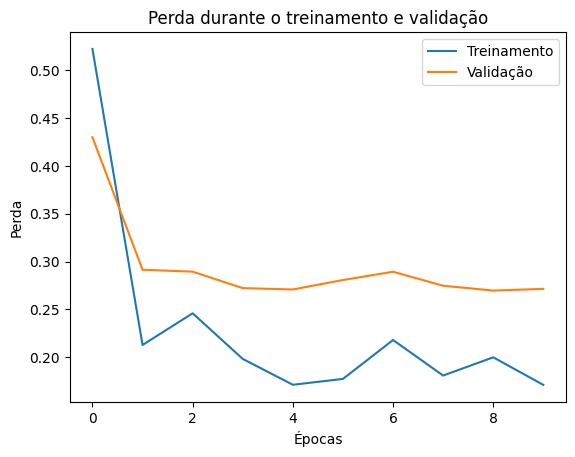

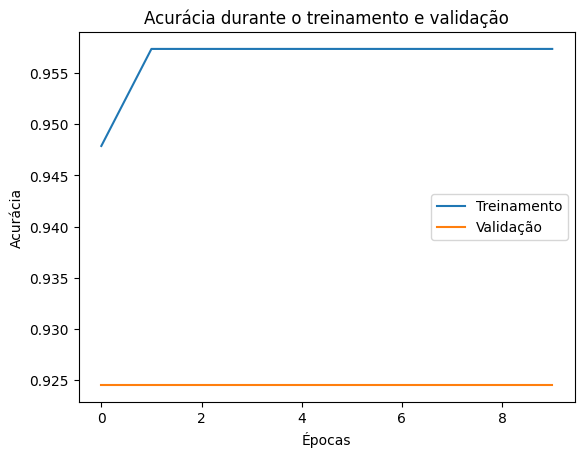

In [24]:
# Plot da perda
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda durante o treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Plot da acurácia
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step


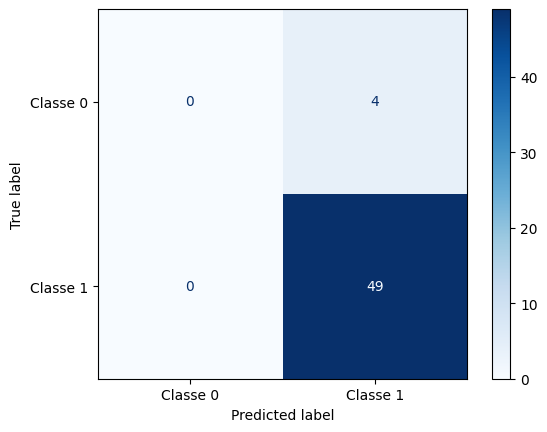

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fazer previsões com o modelo
y_pred = (model.predict(x_test_norm) > 0.5).astype("int32")  # Converter para 0 ou 1

# Criar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe 0', 'Classe 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()
